In [1]:
# Get raw data, convert to csv, and import
# Update directory
import sys
sys.path.insert(1, '../')
# Import libraries
from emm import *
import os.path
from get_data import get_data
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Data locations
processed_dir = "../assets/data/processed/pima_diabetes/"
# Get data into dataframe
df = pd.read_csv(processed_dir + "diabetes.csv",index_col=0)

#train_test_splitting of the dataset
X = df.drop(columns = 'Outcome')
# Getting Predicting Value
y = df['Outcome']

In [2]:
marginals_mean = df.groupby('Outcome').mean()
display(marginals_mean)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164


In [96]:
features = ["Glucose"]
marginals = {}
for feature in features:
    marginals[feature] = ["mean", "mean"]

losses = [KLLoss, EqualityLoss]
    
loss_0 = []
loss_1 = []
for feature in marginals.keys():
        for loss in losses:
            marg = getattr(df[[feature,'Outcome']].groupby('Outcome'),"mean")()
            loss_0.append(loss(marg.loc[0]))
            loss_1.append(loss(marg.loc[1]))
loss_0

In [97]:
#regularizer = regularizers.EntropyRegularizer(limit=None)
regularizer = regularizers.EntropyRegularizer()
w_0, out_0 = emm(X, marginals, loss_0, regularizer=regularizer, optimizer='cvx')
w_1, out_1 = emm(X, marginals, loss_1, regularizer, optimizer='cvx')

In [98]:
X_0 = X.copy()
X_0["weights"] = w_0 
X_1 = X.copy()
X_1["weights"] = w_1 

# Set theoretical outcome to train on reweighted datasets
X_0['Outcome'] = 0
X_1['Outcome'] = 1

df_w = pd.concat([X_0,X_1])

In [99]:
df_valw = df_w.drop(columns=['Outcome','weights']).multiply(df_w['weights'], axis="index")
df_valw['Outcome'] = df_w['Outcome']
w_marginals = df_valw.groupby('Outcome').sum()
display(marginals_mean)
display(w_marginals)
display(abs((marginals_mean - w_marginals)))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.689615,109.871241,67.985386,20.160370,66.236926,31.320423,0.457067,32.147334
1,4.108601,141.178539,71.036162,21.549001,105.764258,33.183128,0.507608,35.337910


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,0.391615,0.772622,2.891953,7.075087,64.050953,0.460749,0.027333,0.957334
1,0.757070,1.141010,4.285267,11.450999,101.081896,2.223639,0.042892,1.729254


In [100]:
import scipy as sp
df[df['Outcome'] == 0].drop('Outcome',axis=1)

#print(sp.special.kl_div(df[df['Outcome'] == 0])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29
10,4,110.0,92.0,NaN,NaN,37.6,0.191,30
...,...,...,...,...,...,...,...,...
762,9,89.0,62.0,NaN,NaN,22.5,0.142,33
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30


In [101]:
np.histogram(np.array(df_w['Glucose'].dropna()))

(array([  8,  38, 174, 298, 322, 250, 176, 108,  88,  64], dtype=int64),
 array([ 44. ,  59.5,  75. ,  90.5, 106. , 121.5, 137. , 152.5, 168. ,
        183.5, 199. ]))

<ipython-input-104-622114e2d971>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  H, bins = np.histogram(np.array(df_w[df["Outcome"]==0].dropna()['Glucose']),
<ipython-input-104-622114e2d971>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weights = np.array(df_w[df["Outcome"]==0].dropna()['weights']), normed = True)
<ipython-input-104-622114e2d971>:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H, bins = np.histogram(np.array(df_w[df["Outcome"]==0].dropna()['Glucose']),
<ipython-input-104-622114e2d971>:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the

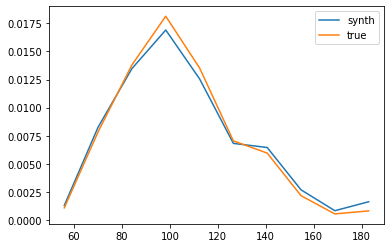

In [104]:
import matplotlib.pyplot as plt
import numpy as np

H, bins = np.histogram(np.array(df_w[df["Outcome"]==0].dropna()['Glucose']), 
                       weights = np.array(df_w[df["Outcome"]==0].dropna()['weights']), normed = True)
plt.plot(bins[:-1],H, label='synth')
H, bins = np.histogram(np.array(df[df["Outcome"]==0].dropna()['Glucose']),normed=True)
plt.plot(bins[:-1],H, label='true')
plt.legend()
plt.show()

<ipython-input-93-2cad3f84d866>:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H, bins = np.histogram(np.array(df[df["Outcome"]==0].dropna()['Glucose']),normed=True)


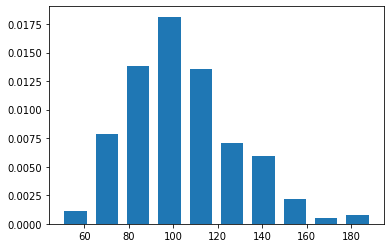

In [93]:
H, bins = np.histogram(np.array(df[df["Outcome"]==0].dropna()['Glucose']),normed=True)
plt.bar(bins[:-1],H,width=10)

plt.show()